In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "FacePix",
    shuffle= True, 
    image_size = (60,51),
    batch_size = 32
)

Found 5430 files belonging to 2 classes.


In [3]:
EPOCHS = 50

In [4]:
import tensorflow as tf
print(tf.__version__)

2.13.1


In [5]:
class_names = dataset.class_names
class_names

['Head_Movement_Allowed', 'Head_Movement_Not_Allowed']

In [6]:
len(dataset)

170

In [7]:
for img, label in dataset.take(1):
 print(img.shape)
 print(label.numpy())

(32, 60, 51, 3)
[0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 0 1]


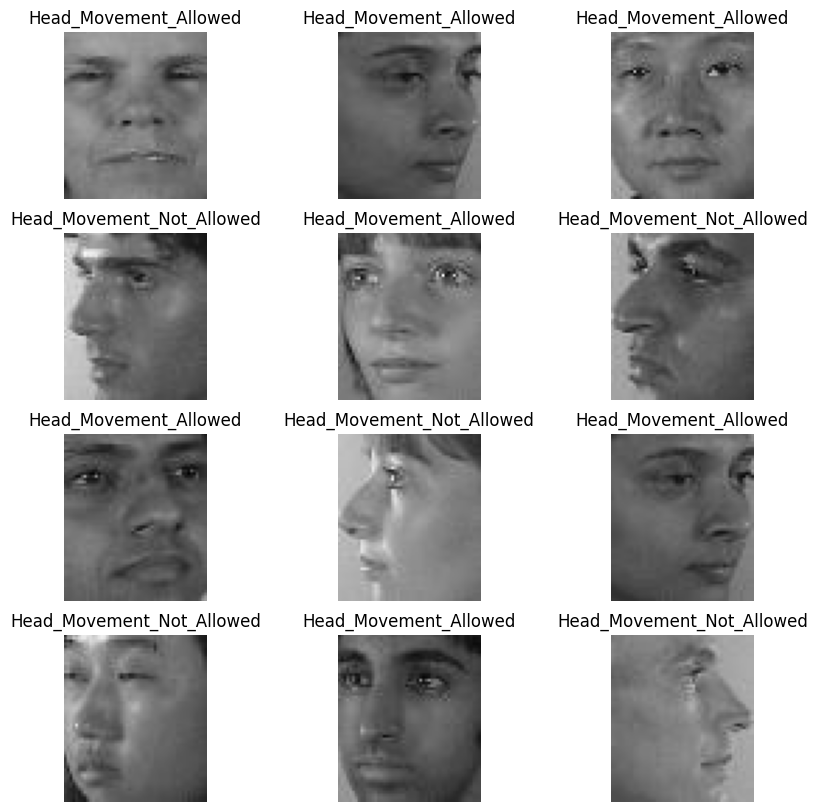

In [8]:
plt.figure(figsize=(10,10))

for img, label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4,3, i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")
 

In [9]:
train_size = 0.8
len(dataset) * train_size

136.0

In [10]:
train_dataset = dataset.take(136)
len(train_dataset)

136

In [11]:
test_dataset = dataset.skip(136)
len(test_dataset)

34

In [12]:
val_size = 0.1  #validation data
len(dataset) * val_size

17.0

In [13]:
val_dataset = test_dataset.take(17)
len(val_dataset)

17

In [14]:
test_dataset = test_dataset.skip(17)
len(test_dataset)

17

In [15]:
def get_dataset_partitions_tf(dataset, train_split= 0.8, val_split= 0.1, test_split= 0.1, shuffle= True, shuffle_size=10000):
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed= 12)
    
    train_size = int(train_split* dataset_size)
    val_size   = int(val_split* dataset_size)
    
    train_dataset = dataset.take(train_size)
    val_dataset   = dataset.skip(train_size).take(val_size)
    test_dataset   = dataset.skip(train_size).skip(val_size)
    
    return train_dataset,  val_dataset, test_dataset

In [16]:
train_dataset,  val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [17]:
len(train_dataset)


136

In [18]:
len(val_dataset)


17

In [19]:
len(test_dataset)

17

In [20]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
#Data Preprocessing

In [24]:


resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(60,51),
    tf.keras.layers.Rescaling(1.0/255)
    
    
    
    
])



In [25]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),  # ADD THIS LINE
])


In [26]:
def preprocess_image(image):
    image = tf.image.rgb_to_grayscale(image)  # Convert RGB to grayscale
    return image

In [27]:
train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), y))
val_dataset = val_dataset.map(lambda x, y: (preprocess_image(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_image(x), y))

In [28]:



# Model Implementation

In [29]:
BATCH_SIZE = 32


n_classes =2 

model = tf.keras.Sequential([
    layers.Input(shape=(60, 51, 1)),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),  # CHANGE (1, 1) TO (3, 3)
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),  # CHANGE (1, 1) TO (3, 3)
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),  # CHANGE THIS LINE (NEW LAYER)
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),  # CHANGE 64 TO 128
    layers.Dropout(0.5),  # ADD THIS LINE
    layers.Dense(n_classes, activation='softmax'),
])



In [30]:
class_counts = [0, 0]
for _, labels in dataset:
    for label in labels:
        class_counts[label.numpy()] += 1

total_samples = sum(class_counts)
class_weights = {0: total_samples/class_counts[0], 1: total_samples/class_counts[1]}  # ADD THIS LINE

In [31]:
model.build(input_shape = (None,60,51,1) )

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 60, 51, 1)         0         
                                                                 
 sequential_1 (Sequential)   (None, 60, 51, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 58, 49, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 11, 64)        0         
 g2D)                                                 

In [33]:
model.compile(

        optimizer = 'adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
        metrics = ['accuracy']


)

In [34]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=32,
    verbose=1,
    validation_data=val_dataset,
    class_weight=class_weights  # ADD THIS LINE
) 

Epoch 1/50
136/136 [==============================] - 15s 91ms/step - loss: 1.3519 - accuracy: 0.5707 - val_loss: 0.6431 - val_accuracy: 0.5202
Epoch 2/50
136/136 [==============================] - 11s 78ms/step - loss: 0.9225 - accuracy: 0.7957 - val_loss: 0.3074 - val_accuracy: 0.9136
Epoch 3/50
136/136 [==============================] - 10s 74ms/step - loss: 0.6049 - accuracy: 0.8874 - val_loss: 0.2186 - val_accuracy: 0.9210
Epoch 4/50
136/136 [==============================] - 10s 75ms/step - loss: 0.4732 - accuracy: 0.9093 - val_loss: 0.1653 - val_accuracy: 0.9412
Epoch 5/50
136/136 [==============================] - 10s 76ms/step - loss: 0.4635 - accuracy: 0.9111 - val_loss: 0.1939 - val_accuracy: 0.9228
Epoch 6/50
136/136 [==============================] - 11s 78ms/step - loss: 0.4088 - accuracy: 0.9242 - val_loss: 0.1654 - val_accuracy: 0.9412
Epoch 7/50
136/136 [==============================] - 11s 78ms/step - loss: 0.3817 - accuracy: 0.9275 - val_loss: 0.1433 - val_accuracy:

In [35]:
scores = model.evaluate(test_dataset)

17/17 [==============================] - 2s 16ms/step - loss: 0.1140 - accuracy: 0.9504


In [36]:
scores

[0.11399593204259872, 0.9503676295280457]

In [37]:
scoress = model.evaluate(train_dataset)

136/136 [==============================] - 2s 15ms/step - loss: 0.0991 - accuracy: 0.9627


In [38]:
scoress

[0.0990663468837738, 0.962689995765686]

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

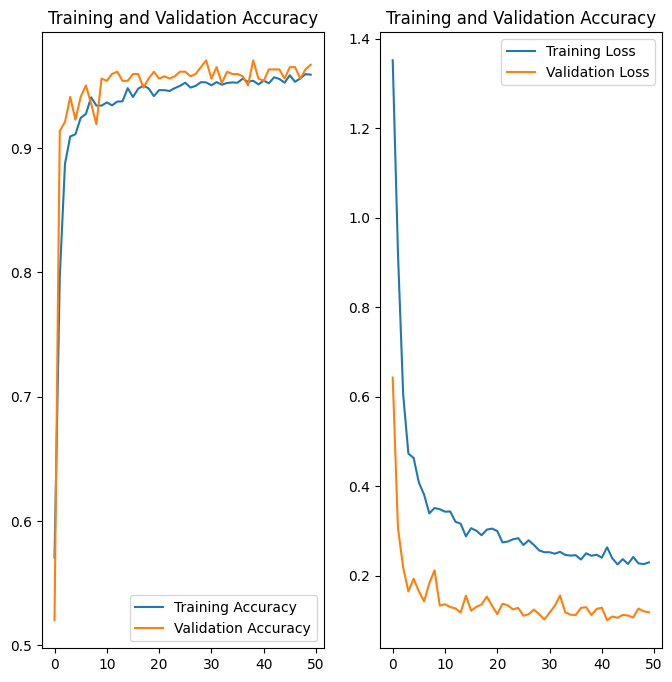

In [41]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')




plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')

IMAGE PREDICTION
Actual Label:  Head_Movement_Not_Allowed
1/1 [==============================] - 0s 99ms/step
Predicted Label:  Head_Movement_Not_Allowed


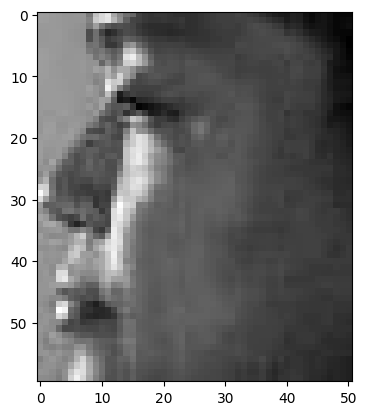

In [42]:
import numpy as np

for img, label in test_dataset.take(1):
    first_image = img[0].numpy().astype("uint8")
    first_label = label[0].numpy()
    
    print("IMAGE PREDICTION")
    plt.imshow(first_image, cmap='gray')
    
    print("Actual Label: ", class_names[first_label])
    
    
    batch_prediction = model.predict(img)
    predict1 = np.argmax(batch_prediction[0])
    print("Predicted Label: ", class_names[predict1])
    

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


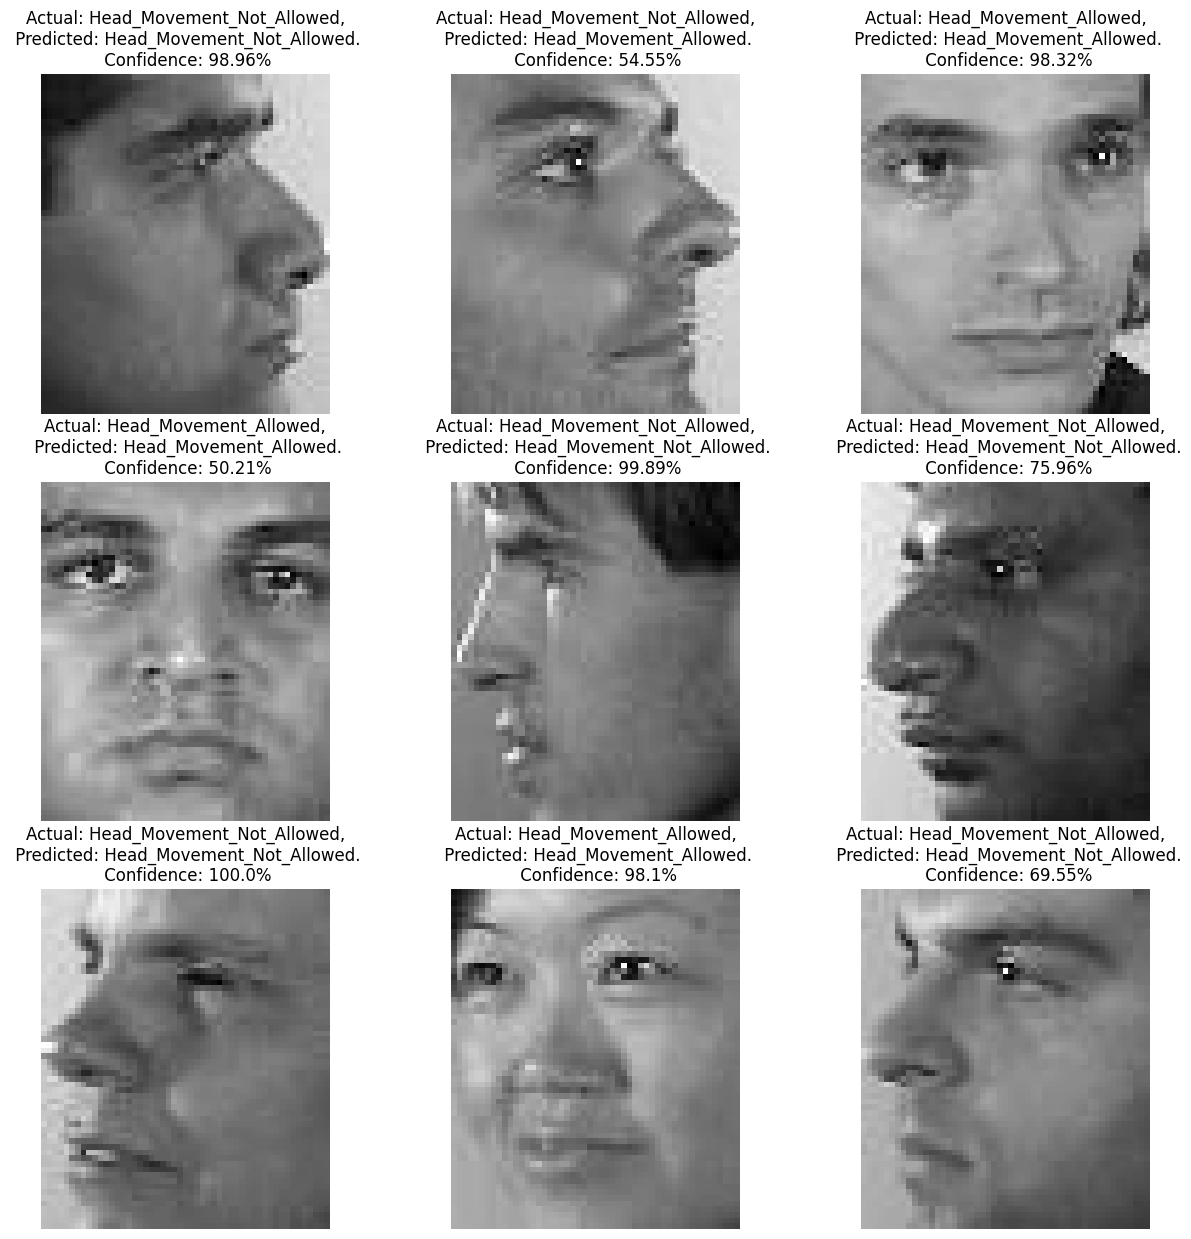

In [44]:
plt.figure(figsize=(15, 15))
for img, label in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"), cmap = 'gray')
        
        predicted_class, confidence = predict(model, img[i])
        actual_class = class_names[label[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        
        

In [46]:

model_version = 'CNN_Model_2'
model.save(f"../models/{model_version}.keras")

1/1 [==============================] - 0s 35ms/step


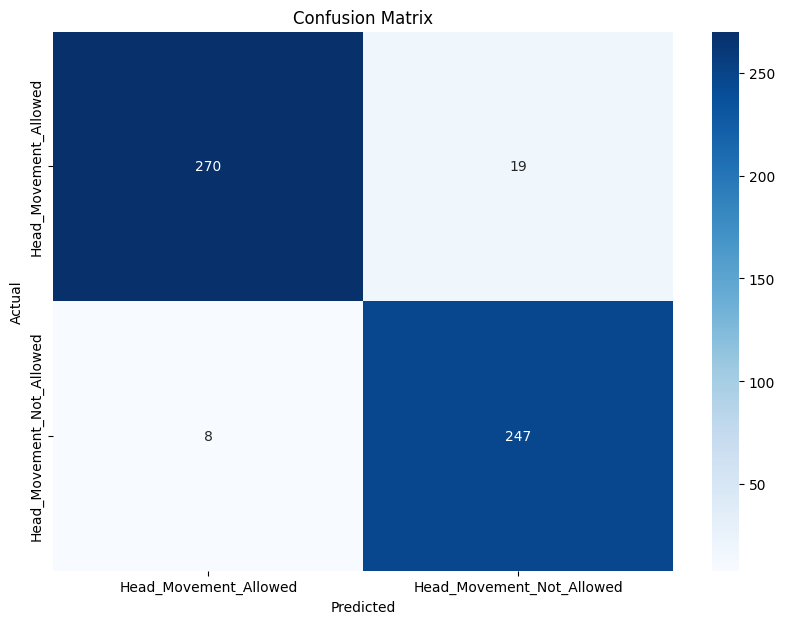

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
y_true = []
y_pred = []

for img, label in test_dataset:
    preds = model.predict(img)
    y_true.extend(label.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()